In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib as mpl
from matplotlib.lines import Line2D

from module.convect.entropy_prep import get_ud_all_ent
from module.convect.vectorisation import get_all_vectorisation
from module.data_prep_drosophila import drosophila_data
from module.data_prep_celegans import celegans_data, syn_to_edge


In [2]:
save_things = False # set as True to save data and figures

if save_things:
    distributions_vis_path = '../figures/distributions_vis'
    if not os.path.isdir(distributions_vis_path):
        os.makedirs(distributions_vis_path)


# _Drosophila_ VNC



## Load data


In [ ]:
datadate = '20241119' # date of drosophila VNC data pull
dm_datadir = f'../../data/{datadate}_dm_data'

if save_things:
    dm_processed_dir = dm_datadir + '/processed'
    if not os.path.isdir(dm_processed_dir):
        os.makedirs(dm_processed_dir)


df, meta_df = drosophila_data(datadate=datadate)

## Hemilineage vectorisation and specialization diversity

In [4]:
h_cat_string = 'hemilineage'
hemilineage_fileprefix = f'{dm_datadir}/processed/hemilineage'

h_cat_meta = meta_df[['bodyId', h_cat_string]].rename(columns={'bodyId':'id', h_cat_string:'type'}).copy(True)

categories = [str(category) for category in h_cat_meta.dropna().type.unique()] 
categories.remove('TBD')
all_hemi_vectors = get_all_vectorisation(df=df, \
                                         meta_df=h_cat_meta, \
                                         Ids=None, \
                                         categories=categories, \
                                         fpath_prefix=hemilineage_fileprefix, \
                                         entropy=True)

# ~6 mins

../data/20241119_dm_data/processed/hemilineage_vec.parquet vector parquet exists.


In [5]:
# Hemilineage vectorisation specialization-diversity
all_hemi_entropies = get_ud_all_ent(df=df, \
                                    meta_df=h_cat_meta, \
                                    categories=categories, \
                                    fpath_prefix=hemilineage_fileprefix)

# ~5.5 mins

../data/20241119_dm_data/processed/hemilineage_ud_ents.parquet upstream/downstream parquet csv exists.


## Network degrees


In [6]:
edges = df.copy(True)
edges['attr'] = [{'weight':i} for i in edges['weight']]
edge_list = edges[['bodyId_pre', 'bodyId_post', 'attr']].to_numpy()
vnc_g = nx.DiGraph()
vnc_g.add_edges_from(edge_list)
deg_cent = nx.degree_centrality(vnc_g)
meta_df['deg'] = meta_df.apply(lambda x: deg_cent.get(x.bodyId), axis=1)


## Plot distribution

In [7]:
cmap = mpl.colormaps['tab10']

In [8]:
plot_df = meta_df.copy(True)
plot_df = plot_df.join(all_hemi_entropies, on='bodyId')
plot_df['class'] = plot_df['class'].astype(str)

# save as csv
if save_things:
    plot_df.to_csv(dm_datadir + '/processed/all_dm_sd.csv')



In [9]:
class_filtered_df = plot_df[~plot_df['class'].isin(['glia','TBD', 'nan', 'Unknown', None])].copy(True)


In [10]:
cclasses=['descending neuron', 'sensory neuron', 'motor neuron', 'intrinsic neuron', 'ascending neuron']
toplot_class_filtered_df= class_filtered_df[class_filtered_df['class'].isin(cclasses)]


In [11]:
entropy_hubs = all_hemi_entropies[f'out_diff_ds'] + all_hemi_entropies[f'in_diff_us']
entropy_hubs = entropy_hubs.sort_values(ascending=False)
entropy_hubs = entropy_hubs.iloc[:10].index.values

ent_hub_df = toplot_class_filtered_df[toplot_class_filtered_df.bodyId.isin(entropy_hubs)].copy(True)



In [12]:
# to_plot = meta_df.copy(True).reset_index()
# to_plot = to_plot.join(all_hemi_entropies, on='bodyId')

cellclass_string= 'class'
toplot_class_filtered_df[cellclass_string] = toplot_class_filtered_df[cellclass_string].astype(str)


# ud = 'ds'

fig = px.scatter(toplot_class_filtered_df, x=f"out_diff_ds", y=f"in_diff_us", color=cellclass_string, 
                 hover_data=['bodyId'], labels={f'out_diff_ds':"Out-entropy averages' difference", f'in_diff_us':"In-entropy averages' difference"},
                 title=f'<i>Drosophila</i> hemilineage vectorisation specialization-diversity')

# cellclass_entropy_hubs = ent_diff_hubs(all_entropies=all_hemi_entropies, \
#                                        ud=ud,trunc=10).index.values

# ent_hub_df = to_plot[to_plot.bodyId.isin(cellclass_entropy_hubs)].copy(True)

fig.add_trace(go.Scatter(
    x = ent_hub_df[f'out_diff_ds'],
    y = ent_hub_df[f'in_diff_us'],
    mode='markers',
    marker=dict(
        size=12,
        color='red',
        line=dict(width=2, color='red'),
        symbol= 'square-open' #117
    ),
    # fillcolor='red',
    hovertext=ent_hub_df.bodyId,
    name='Entropic hubs'

))

# L = 10126
# R = 10118

# ids_to_inspect = [26720, 22412, 14007, 16082, 15993]
# cellclass_entropy_toinspect = all_hemi_entropies.loc[ids_to_inspect]

# ent_inspect_df = to_plot[to_plot.bodyId.isin(ids_to_inspect)].copy(True)

# fig.add_trace(go.Scatter(
#     x = ent_inspect_df[f'out_diff_{ud}'],
#     y = ent_inspect_df[f'in_diff_{ud}'],
#     mode='markers',
#     marker=dict(
#         size=12,
#         color='white',
#         line=dict(width=2, color='red'),
#         symbol= '0' #117
#     ),
#     # fillcolor='red',
#     hovertext=ent_inspect_df.bodyId,
#     name='Ids to inspect'

# ))

fig.update_layout()




full_fig = fig.full_figure_for_development(warn=False)
xrange = full_fig.layout.xaxis.range
yrange = full_fig.layout.yaxis.range
fig.update_layout(xaxis_range=xrange, yaxis_range=yrange,
                      autosize=False,
                      width=800,
                      height=500,)


fig.show()

if save_things:
    fig.write_html(f"../figures/distributions_vis/drosophila_hemi_sd_distributions.html")


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_60489/2177961700.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toplot_class_filtered_df[cellclass_string] = toplot_class_filtered_df[cellclass_string].astype(str)


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_60489/4211432602.py:52: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_60489/4211432602.py:52: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.



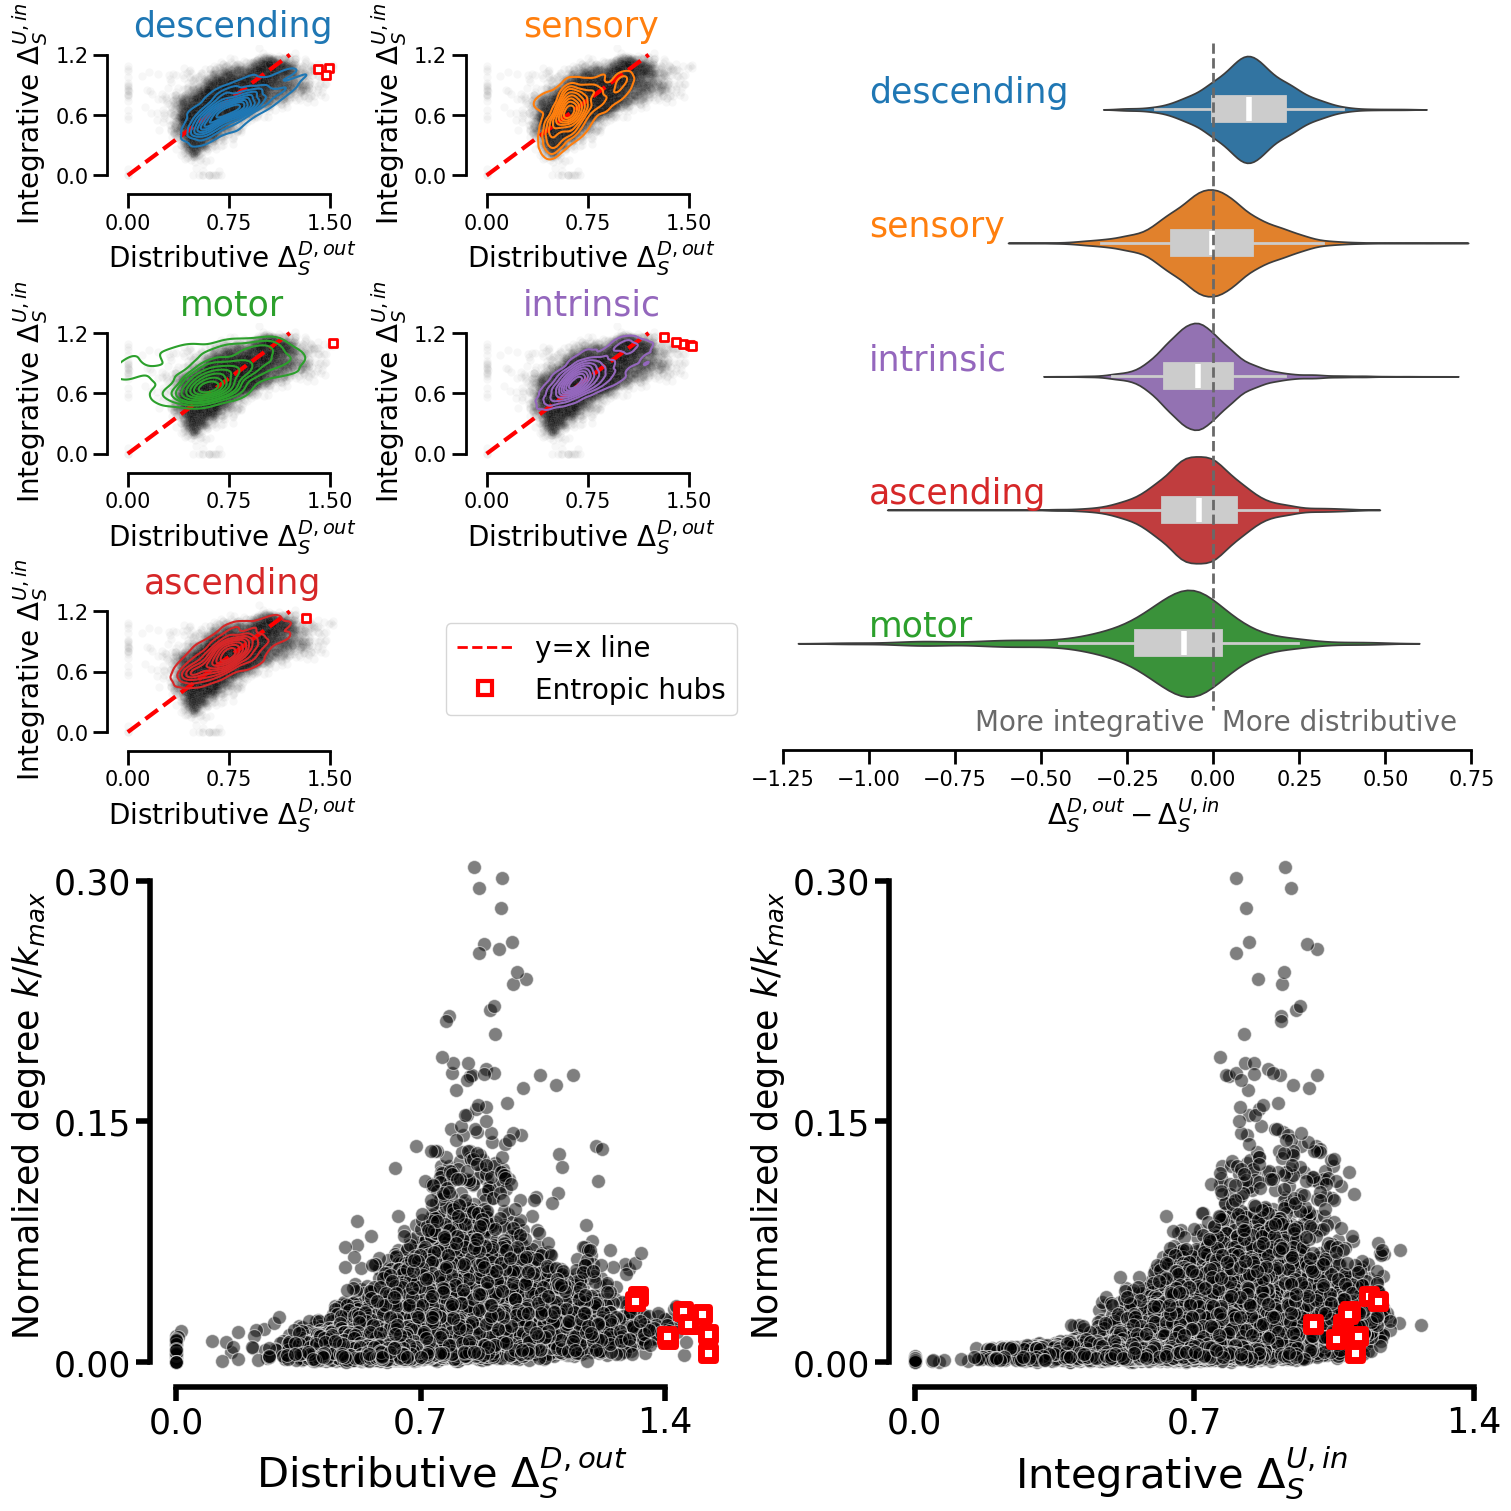

In [15]:
cclasses=['descending neuron', 'sensory neuron', 'motor neuron', 'intrinsic neuron', 'ascending neuron']
cmap_ind = [0,1,2,4,3] #range(len(cclasses))
classmap = dict(zip(cclasses, [cmap(i) for i in cmap_ind]))


fig = plt.figure(layout="constrained", figsize=(15,15))
gs = GridSpec(2, 1, figure=fig, height_ratios=[5,4])

ent_hub_deg_ax = GridSpecFromSubplotSpec(1,2, subplot_spec=gs[1])
first_ax_split = GridSpecFromSubplotSpec(1,2, subplot_spec=gs[0])
div_distributions_ax = GridSpecFromSubplotSpec(3,2, subplot_spec=first_ax_split[0])
ds_out_deg_ax = fig.add_subplot(ent_hub_deg_ax[0])
us_in_deg_ax = fig.add_subplot(ent_hub_deg_ax[1])
int_dist_ax = fig.add_subplot(first_ax_split[1])



## part A
for ind, ith in enumerate(cclasses):
    ith_df = toplot_class_filtered_df[toplot_class_filtered_df['class']==ith].copy()
    ith_ent_hub_df = ent_hub_df[ent_hub_df['class']==ith].copy()
    ax1 = fig.add_subplot(div_distributions_ax[ind])
    sns.scatterplot(toplot_class_filtered_df, ax=ax1, x= "out_diff_ds", y="in_diff_us", alpha=0.03, color='black')
    ax1.plot([0, 1.2], [0, 1.2], 'r--', label='y=x line', linewidth=3)
    sns.kdeplot(data=ith_df, ax=ax1, x= "out_diff_ds", y="in_diff_us",color=classmap[ith])
    sns.scatterplot(ith_ent_hub_df, ax=ax1, x= "out_diff_ds", y="in_diff_us", marker='s', s=40, color='white', linewidth= 2, edgecolor='red', label=r'Entropic hubs', )
    ax1.set_xlabel(r'Distributive $\Delta_S^{D, out}$', size=20)
    ax1.set_ylabel(r'Integrative $\Delta_S^{U, in}$', size=20)
    ax1.set_xlim([-0.05, 1.6 ])
    ax1.set_ylim([-0.05, 1.3 ])
    ax1.set_yticks([0, 0.6, 1.2])
    ax1.set_xticks([0, 0.75, 1.5])
    sns.despine(ax=ax1, offset=10, trim=True)
    ax1.set_title(ith.split()[0], size=25, color=classmap[ith])
    ax1.legend()
    ax1.get_legend().remove()
    ax1.tick_params(width=2, size=10, labelsize=15)
    for pos in ['bottom','left',]:
        ax1.spines[pos].set_linewidth(2)

legend_elements = [Line2D([0], [0], color='r', lw=2, ls='--', label='y=x line'),
                   Line2D([0], [0], marker='s', label='Entropic hubs', color='w',
                          markerfacecolor='white', markeredgecolor='red', markersize=10, markeredgewidth=3)]
legend_ax = fig.add_subplot(div_distributions_ax[ind+1])
legend_ax.legend(handles=legend_elements, loc='center',fontsize=20)
legend_ax.axis('off')


# part B
toplot_class_filtered_df.loc[:,'dsout_usin_diff'] = toplot_class_filtered_df[f'out_diff_ds'] - toplot_class_filtered_df[f'in_diff_us'] 
plot_order = toplot_class_filtered_df.groupby('class').dsout_usin_diff.mean().sort_values(ascending=False).index.values
sns.violinplot(toplot_class_filtered_df,x='dsout_usin_diff', y='class', fill=True, scale="area", common_norm=False, alpha=1, ax=int_dist_ax, order=plot_order, palette=classmap, inner_kws=dict(box_width=20, whis_width=2, color=".8"))
sns.despine(offset=5, trim=True, left=True, ax=int_dist_ax)
int_dist_ax.set(yticklabels=[])  # remove the tick labels
int_dist_ax.tick_params(left=False)  # remove the ticks

int_dist_ax.set_xlabel(r'$\Delta_S^{D, out} - \Delta_S^{U, in}$', size=20)
int_dist_ax.set_ylabel('', size=20)

for ind, cclass in enumerate(plot_order):
    int_dist_ax.annotate(
        cclass.split()[0], xy=(-1, ind), verticalalignment="bottom",
        color=classmap[cclass], size=25)  # custom properties
    
int_dist_ax.tick_params(width=2, size=10, labelsize=15)
int_dist_ax.spines['bottom'].set_linewidth(2)
int_dist_ax.plot([0 for i in range(len(cclasses))], np.linspace(-0.5,len(cclasses)-0.5, len(cclasses)), linestyle='dashed', color='dimgrey', linewidth=2)
int_dist_ax.annotate('More integrative ', xy=(0, ind+.7), horizontalalignment='right', verticalalignment="bottom", size=20, color='dimgrey')
int_dist_ax.annotate(' More distributive', xy=(0, ind+.7), horizontalalignment='left', verticalalignment="bottom", size=20, color='dimgrey')


# part E
cent_measure='deg'
cols = ['out_diff_ds', 'in_diff_us']
plottype = zip(cols, [ds_out_deg_ax, us_in_deg_ax], ['Distributive', 'Integrative'])
for i, col in enumerate(plottype):
    cent = col[0]
    axis = col[1]
    xname = col[2]

    sns.scatterplot(y=toplot_class_filtered_df[cent_measure], x=toplot_class_filtered_df[cent], alpha=0.5, marker='o', color='black', ax=axis, s=100)
    colsplit = cent.split('_')
    xlabel = xname + ' ' + rf'$\Delta_S^{{{str.upper(colsplit[-1][0])}, {colsplit[0]}}}$'
    axis.set_xlabel(xlabel,size=30 )
    sns.scatterplot(ent_hub_df, y=cent_measure, x=cent, marker='s', 
                     color='white', linewidth= 5, edgecolor='red', label=r'Entropic hubs',ax=axis, s=100)
    axis.set_xticks([0, 0.7, 1.4])
    axis.set_ylabel(r'Normalized degree $k/k_{max}$', size=25)
    axis.set_yticks([0, 0.15, 0.3])

    axis.tick_params(width=4, size=10)
    for pos in ['bottom','left',]:
        axis.spines[pos].set_linewidth(4)
    axis.tick_params(axis='x', labelsize=25)
    axis.tick_params(axis='y', labelsize=25)
    axis.get_legend().remove()
    sns.despine(ax=axis, trim=True)

if save_things:
    plt.savefig('../figures/r1_sd_distributions_A_B_E_drosophila.png', dpi=300)
plt.show()



# _C. elegans_

## Load data

In [ ]:
if save_things:
    ce_processed_dir = '../../data/celegans/processed'
    if not os.path.isdir(ce_processed_dir):
        os.makedirs(ce_processed_dir)

In [17]:
edge_df, ce_meta = celegans_data()

/Users/ssm47/Desktop/thesis_code/02_spec_div/src/module/data_prep_celegans.py:74: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [18]:
chem_edges_df = syn_to_edge(edge_df, electrical=False)

all_edges_df = syn_to_edge(edge_df, electrical=True)

In [24]:
strings_list = ['Anatomical cell class (WW Barry)', 'Cook cell category', 'Cell Class', 'Final classification']

shorthand = {'Anatomical cell class (WW Barry)':'cellclass', \
             'Cook cell category':'cook_ccat', \
             'Cell Class':'ncclass', 'Final classification':'fclass'}

edge_dict = {'chem':chem_edges_df, 'all':all_edges_df}


for class_string in strings_list:
    class_meta = ce_meta.reset_index()[['Neuron', class_string]].rename(columns={'Neuron':'id', class_string:'type'}).copy(True)
    class_name = shorthand.get(class_string)
    todir = f'../data/celegans/processed/{class_name}'
    if not os.path.isdir(todir):
        os.mkdir(todir)
    for edgetype in edge_dict.keys():
        typeedge_df = edge_dict.get(edgetype)
        edgetype_class_ents = get_ud_all_ent(df=typeedge_df, \
                                             meta_df=class_meta, \
                                             categories=None, \
                                             fpath_prefix=f'{todir}/V_{class_name}_{edgetype}')
# 44s

../data/celegans/processed/cellclass/V_cellclass_chem_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/cellclass/V_cellclass_all_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/cook_ccat/V_cook_ccat_chem_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/cook_ccat/V_cook_ccat_all_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/ncclass/V_ncclass_chem_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/ncclass/V_ncclass_all_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/fclass/V_fclass_chem_ud_ents.parquet upstream/downstream parquet csv exists.
../data/celegans/processed/fclass/V_fclass_all_ud_ents.parquet upstream/downstream parquet csv exists.


## Network degrees

In [25]:
edges = all_edges_df.copy(True)

edges['attr'] = [{'weight':i} for i in edges['weight']]
edge_list = edges[['pre', 'post', 'attr']].to_numpy()
g = nx.DiGraph()
g.add_edges_from(edge_list)
n = len(g)
deg_cent = nx.degree_centrality(g)
ce_meta['deg'] = ce_meta.apply(lambda x: deg_cent.get(x.name), axis=1) #* (n-1)


## Plot distribution
Cook cell categorisation as annotation scheme for vectorisation and entropy calculations:


In [26]:
cmap = mpl.colormaps['tab10']

In [ ]:

class_string = 'Cook cell category'
class_name = shorthand.get(class_string)

edgetype='all'
ent_dir = f'../../data/celegans/processed/{class_name}/V_{class_name}_{edgetype}_ud_ents.parquet'
vec_dir = f'../../data/celegans/processed/{class_name}/V_{class_name}_{edgetype}_vec.parquet'

read_vec = pd.read_parquet(vec_dir)
vecs = read_vec.iloc[:, :-2]
vec_ent = read_vec.iloc[:, -2:]


spec_div = pd.read_parquet(ent_dir)



In [ ]:
to_plot = ce_meta.copy(True).reset_index()
to_plot = to_plot.join(spec_div, on='Neuron')

# save as csv
if save_things:
    to_plot.to_csv('../../data/celegans/processed/all_ce_sd.csv') # all c. elegans specialization-diversity distributions



In [29]:




class_vis = 'Final classification'
fig = px.scatter(to_plot, x=f"out_diff_ds", y=f"in_diff_us", color=class_vis, 
                 hover_data=['Neuron'], labels={f'out_diff_ds':"Downstream out-entropy averages' difference", f'in_diff_us':" Upstream in-entropy averages' difference"},
                 title=f'<i>C. elegans</i> {class_string} vectorisation specialization-diversity, {edgetype} edges')

entropy_hubs = spec_div[f'out_diff_ds'] + spec_div[f'in_diff_us']
entropy_hubs = entropy_hubs.sort_values(ascending=False)
entropy_hubs = entropy_hubs.iloc[:10].index.values
ent_hub_df = to_plot[to_plot.Neuron.isin(entropy_hubs)].copy(True)

fig.add_trace(go.Scatter(
    x = ent_hub_df[f'out_diff_ds'],
    y = ent_hub_df[f'in_diff_us'],
    mode='markers',
    marker=dict(
        size=12,
        color='red',
        line=dict(width=2, color='red'),
        symbol= 'square-open' #117
    ),
    hovertext=ent_hub_df.Neuron,
    name='Entropic hubs'

))


fig.update_layout()

full_fig = fig.full_figure_for_development(warn=False)
xrange = full_fig.layout.xaxis.range
yrange = full_fig.layout.yaxis.range
fig.update_layout(xaxis_range=xrange, yaxis_range=yrange,
                      autosize=False,
                      width=800,
                      height=500,)

d = fig.data
fig.data = d[::-1]

fig.show()
if save_things:
    fig.write_html(f"../figures/distributions_vis/celegans_{class_name}_sd_distributions.html")


In [30]:

fig_to_plot = to_plot.rename(columns={'Final classification':'Cell class', 'deg':'Degree'})
fig_to_plot = fig_to_plot[fig_to_plot['Cell class']!='unknown']
ent_hub_df = fig_to_plot[fig_to_plot.Neuron.isin(entropy_hubs)].copy(True)


In [31]:
cclasses=['Pharynx', 'sensory neuron', 'motor neuron', 'interneuron']

cmap_ind = [9, 1, 2, 4]

classmap = dict(zip(cclasses, [cmap(i) for i in cmap_ind]))


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_60489/1751505992.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




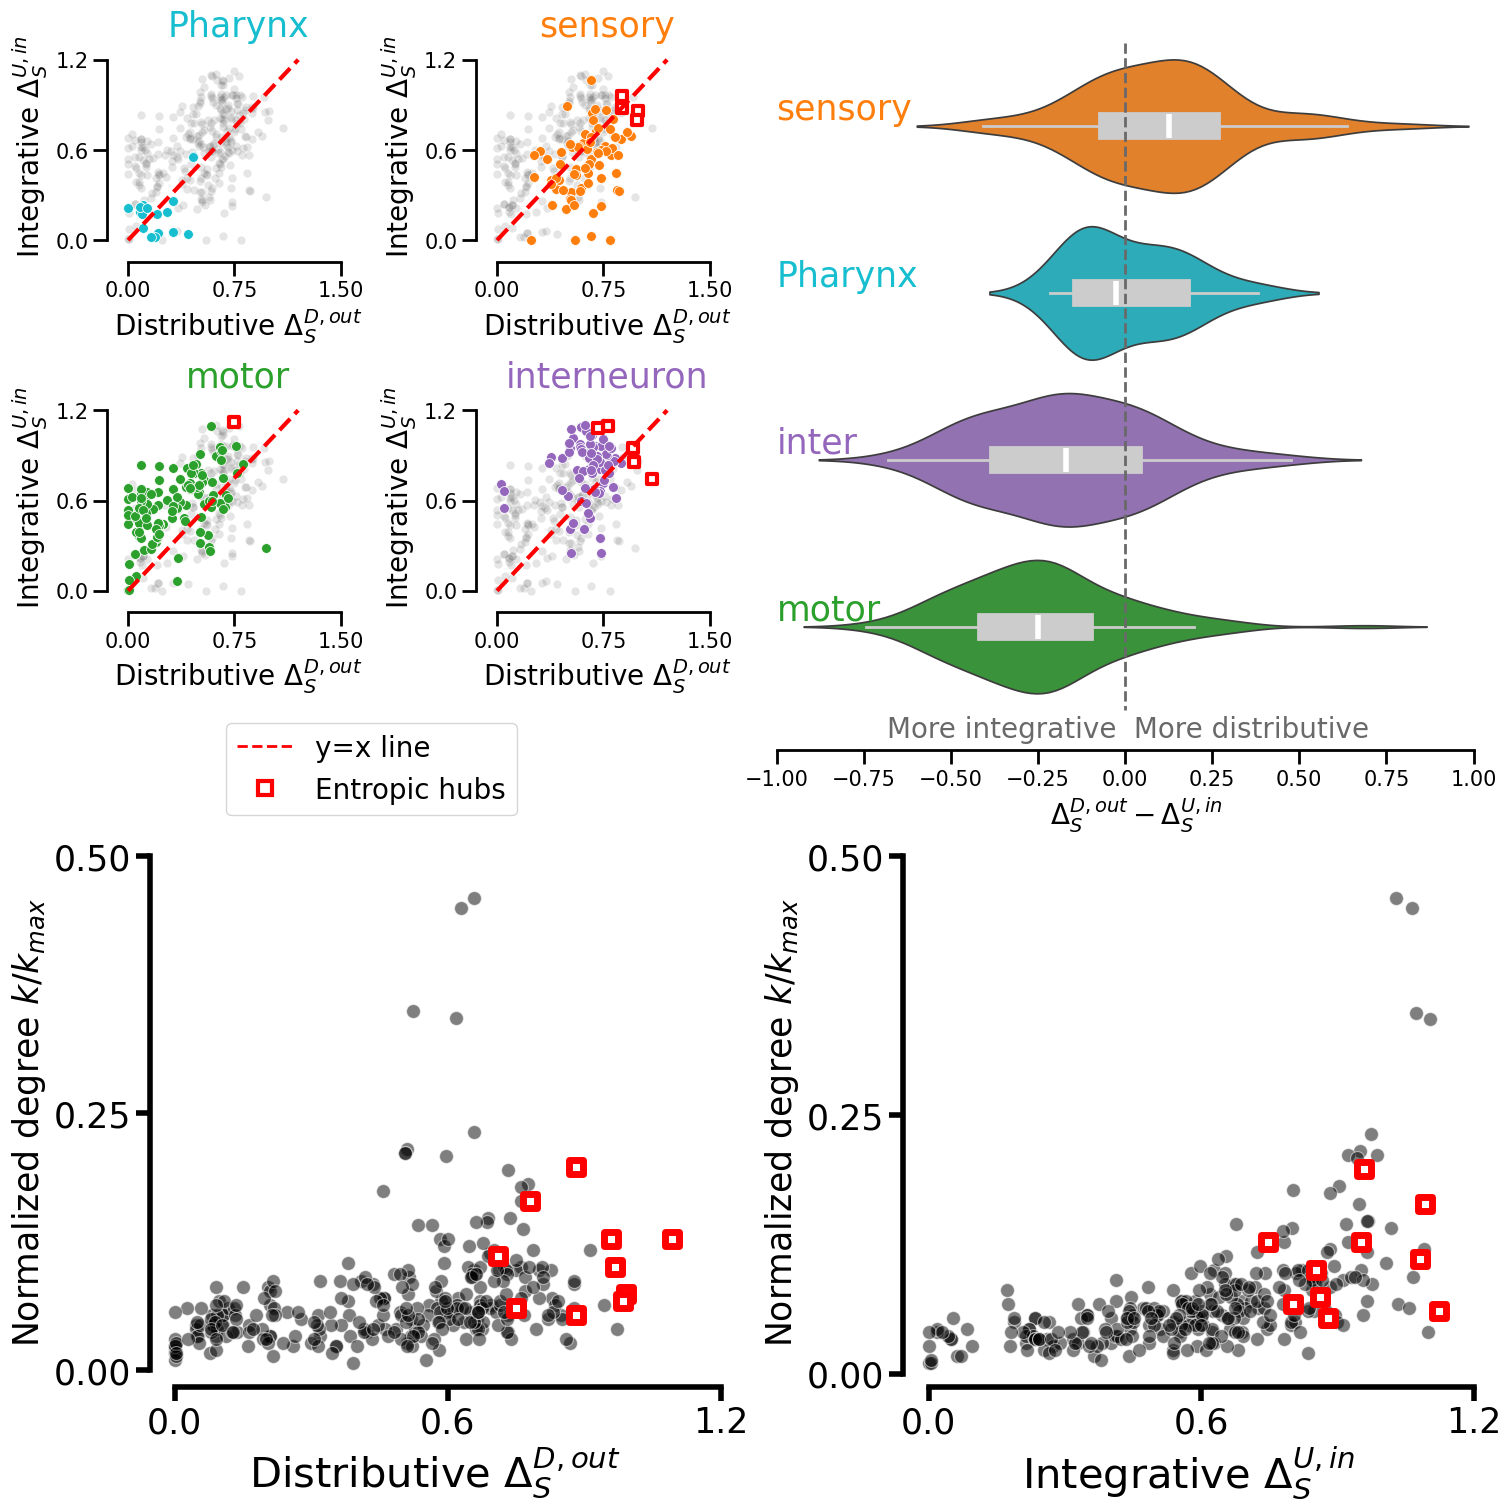

In [34]:
cc_colname = 'Cell class'

fig = plt.figure(layout="constrained", figsize=(15,15))

gs = GridSpec(2, 1, figure=fig, height_ratios=[5,4])

ent_hub_deg_ax = GridSpecFromSubplotSpec(1,2, subplot_spec=gs[1])

first_ax_split = GridSpecFromSubplotSpec(1,2, subplot_spec=gs[0])

first_quadrant_split = GridSpecFromSubplotSpec(2,1, subplot_spec=first_ax_split[0], height_ratios=[5,1])

div_distributions_ax = GridSpecFromSubplotSpec(2,2, subplot_spec=first_quadrant_split[0])
legend_gs = GridSpecFromSubplotSpec(1,1, subplot_spec=first_quadrant_split[1])
legend_ax = fig.add_subplot(legend_gs[0])

ds_out_deg_ax = fig.add_subplot(ent_hub_deg_ax[0])
us_in_deg_ax = fig.add_subplot(ent_hub_deg_ax[1])
int_dist_ax = fig.add_subplot(first_ax_split[1])


toplot_layer_meta = fig_to_plot[fig_to_plot[cc_colname].isin(cclasses)]

toplot_layer_meta.loc[:,'dsout_usin_diff'] = toplot_layer_meta[f'out_diff_ds'] - toplot_layer_meta[f'in_diff_us'] 
plot_order = toplot_layer_meta.groupby(cc_colname).dsout_usin_diff.mean().sort_values(ascending=False).index.values
sns.violinplot(toplot_layer_meta,x='dsout_usin_diff', y=cc_colname, fill=True, common_norm=False, alpha=1, ax=int_dist_ax, order=plot_order, palette=classmap, inner_kws=dict(box_width=20, whis_width=2, color=".8"))
sns.despine(offset=5, trim=True, left=True, ax=int_dist_ax)
int_dist_ax.set(yticklabels=[])  # remove the tick labels
int_dist_ax.tick_params(left=False)  # remove the ticks

int_dist_ax.set_xlabel(r'$\Delta_S^{D, out} - \Delta_S^{U, in}$', size=20)
int_dist_ax.set_ylabel('', size=20)
for ind, cclass in enumerate(plot_order):
    int_dist_ax.annotate(
        cclass.split('neuron')[0].strip(), xy=(-1, ind), verticalalignment="bottom",
        color=classmap[cclass], size=25)  # custom properties
    
int_dist_ax.annotate('More integrative ', xy=(0, ind+.7), horizontalalignment='right', verticalalignment="bottom", size=20, color='dimgrey')
int_dist_ax.annotate(' More distributive', xy=(0, ind+.7), horizontalalignment='left', verticalalignment="bottom", size=20, color='dimgrey')

int_dist_ax.tick_params(width=2, size=10, labelsize=15)
int_dist_ax.spines['bottom'].set_linewidth(2)
int_dist_ax.plot([0 for i in range(len(cclasses))], np.linspace(-0.5,len(cclasses)-0.5, len(cclasses)), linestyle='dashed', color='dimgrey', linewidth=2)


cent_measure='Degree'
cols = ['out_diff_ds', 'in_diff_us']
plottype = zip(cols, [ds_out_deg_ax, us_in_deg_ax], ['Distributive', 'Integrative'])
for i, col in enumerate(plottype):
    cent = col[0]
    axis = col[1]
    xname = col[2]
    sns.scatterplot(y=fig_to_plot[cent_measure], x=fig_to_plot[cent], alpha=0.5, marker='o', color='black', ax=axis, s=100)
    colsplit = cent.split('_')
    xlabel = xname + ' ' + rf'$\Delta_S^{{{str.upper(colsplit[-1][0])}, {colsplit[0]}}}$'
    axis.set_xlabel(xlabel,size=30 )
    sns.scatterplot(ent_hub_df, y=cent_measure, x=cent, marker='s', 
                     color='white', linewidth= 5, edgecolor='red', label=r'Entropic hubs',ax=axis, s=100)
    axis.set_xticks([0, 0.6, 1.2])
    axis.set_ylabel(r'Normalized degree $k/k_{max}$', size=25)
    axis.set_yticks([0, 0.25, 0.5])

    axis.tick_params(width=4, size=10)
    for pos in ['bottom','left',]:
        axis.spines[pos].set_linewidth(4)
    axis.tick_params(axis='x', labelsize=25)
    axis.tick_params(axis='y', labelsize=25)
    axis.get_legend().remove()
    sns.despine(ax=axis, trim=True)





for ind, ith in enumerate(cclasses):

    ith_df = fig_to_plot[fig_to_plot[cc_colname]==ith].copy()
    ith_ent_hub_df = ent_hub_df[ent_hub_df[cc_colname]==ith].copy()

    ax1 = fig.add_subplot(div_distributions_ax[ind])


    sns.scatterplot(fig_to_plot, ax=ax1, x= "out_diff_ds", y="in_diff_us", alpha=0.1, color='black')
    ax1.plot([0, 1.2], [0, 1.2], 'r--', label='y=x line', linewidth=3)
    sns.scatterplot(data=ith_df, ax=ax1, x= "out_diff_ds", y="in_diff_us",color=classmap[ith],  s=50)
    sns.scatterplot(ith_ent_hub_df, ax=ax1, x= "out_diff_ds", y="in_diff_us", marker='s', s=60, color='white', linewidth= 3, edgecolor='red', label=r'Entropic hubs', )
    ax1.set_xlabel(r'Distributive $\Delta_S^{D, out}$', size=20)
    ax1.set_ylabel(r'Integrative $\Delta_S^{U, in}$', size=20)

    ax1.set_xlim([-0.05, 1.6 ])
    ax1.set_ylim([-0.05, 1.3 ])

    ax1.set_yticks([0, 0.6, 1.2])
    ax1.set_xticks([0, 0.75, 1.5])


    sns.despine(ax=ax1, offset=10, trim=True)

    ax1.set_title(ith.split()[0], size=25, color=classmap[ith])
    ax1.legend()
    ax1.get_legend().remove()
    ax1.tick_params(width=2, size=10, labelsize=15)
    for pos in ['bottom','left',]:
        ax1.spines[pos].set_linewidth(2)

legend_elements = [Line2D([0], [0], color='r', lw=2, ls='--', label='y=x line'),
                   Line2D([0], [0], marker='s', label='Entropic hubs', color='w',
                          markerfacecolor='white', markeredgecolor='red', markersize=10, markeredgewidth=3)]
legend_ax.legend(handles=legend_elements, loc='center',fontsize=20)
legend_ax.axis('off')

if save_things:
    plt.savefig('../figures/r1_sd_distributions_C_D_F_celegans.png', dpi=300)
plt.show()

